# 基于动态时间弯曲方法（DTW）寻找趋势相似的股票-edit

## 前言
1.本文最早思路来自国信证券 2011-12-26 研报《基于动态时间弯曲的形态匹配在指数增强中的实证研究》。本文在此基础上单独拎出该算法，研究其在寻找股票相同走势方面的应用。

2.动态时间弯曲算法（Dynamic Time Warping Algorithm）最早用于语音识别等领域，它针对的是匹配的时间序列在时间轴上不完全一致的情形，比如，同一个人在不同情境下语速会不同，时间上表示为伸缩的频度不同，但仍可以通过一定算法进行匹配和识别。那么我们可以把类似思想用于市场技术分析领域，当我们定义一种市场形态时，需要回溯历史找到类似的市场形态，该算法可以良好的解决“时间弯曲”（时间不对应，但形态类似）的问题。

对于“时间弯曲”，举个栗子：

时间弯曲

如图所示，黑线表示两个序列映射关系，通过该映射，两个序列间的距离最小，相似度最大。

## 一、算法介绍
* 1.弯曲路径的介绍
为了使介绍更加清晰，举例说明。有A、B两个序列，A=（1，1，1，10，2，3），B=（1，1，1，2，10，3）。若用欧式距离（各元素差的平方和）测量相似度，则distance(A,B)=128, 距离值较大。但如果将A的第三个“1”对应B的第四个“2”，使A的“10”与B的“10”对应，距离就大大减少，变为2。

具体计算过程：

设有两个时间序列A，B，长度分别为n和m。其中 A=a1,a2,...,an; B=b1,b2,...,bm。动态时间弯曲算法的递推公式如下：

递推公式

通过这个算法，我们可以验证上面给出的A和B两个序列的例子，得到的accumulate_distance(A,B)=2,刚好为我们将A的第三个“1”对应B的第四个“2”，A的“10”与B的“10”对应后得到的距离。

* 2.关于程序的说明
（1）DTW算法程序稍微复杂，由于有现成的，我们可以在JoinQuant平台中导入dtw包来实现。该包不仅可以输入数字的序列，也可以输入字符串的序列。但是输入不同类型的序列时，对应输入的dist函数也不同。本文只研究该方法在股票走势上的匹配，采用的距离算法为euclidean_distances，具体参见下方程序。

（2）本文程序中用于筛选两个走势相似股票时，是求总的所给两支股票序列的distance，然后对这个distance要赋予阈值（代码中dist_threshold），小于这个值认为股票走势相近。其中代码第44行“acc[-1][-1]”，acc是运用dtw包得出来的一个距离矩阵，该距离矩阵是累计的距离矩阵。为了说明白，我们仍以上面A、B两个序列为例，A=（1，1，1，10，2，3），B=（1，1，1，2，10，3）。那么得到的acc就是下面的矩阵：

acc距离矩阵

如图所示，矩阵中的每个元素表明了对应的累计distance，但由于我们一直选最短的，从A中的第一个元素“1”和B中的第一个元素“1”对应开始，我们得到灰色的弯曲路径，最终求得accumulate_distance(A,B)=2。

## 二、具体做法
* 1.选取股票池的所有股票，并对其价格归一化。
因为dist_threshold是我们自己设定的，但各个股票价格差别巨大，统一阈值不好判断，所以要规范处理，把所有股票的价格变动都转化为0-1之间。处理方法是：

归一化

这样我们就把所有股票价格转化为0-1之间的变动了。

* 2.求股票上三角矩阵中的两两匹配
为了节约计算时间，同时也能够遍历所有两两配对的股票不产生遗漏，我们可以想象一个由股票池所有股票构成的accumulate_distance矩阵，由于accumulate_distance(A,B)=accumulate_distance(B,A),所以我们只求对角线以上的即可。

由于dtw的运算时间很长，我们设定了print时间，帮助我们知道程序在运行。。。

下面我们先看看当阈值dist_threshold设定为3时候，找的股票长得如何，符不符合直观感觉（由于运行时间太长了，所以先找到一个符合的就停止）。

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
from dtw import dtw
from sklearn.metrics.pairwise import euclidean_distances
import time
from numpy import inf
from jqdatasdk import *

pool = Series(get_index_stocks('000016.XSHG'))
print(pool.head())

ModuleNotFoundError: No module named 'dtw'

2019-12-30 10:18:33
2019-12-30 10:18:35
2019-12-30 10:18:35
2019-12-30 10:18:35
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:36
2019-12-30 10:18:37
2019-12-30 10:18:37
2019-12-30 10:18:37
2019-12-30 10:18:37
2019-12-30 10:18:37
2019-12-30 10:18:37
2019-12-30 10:18:38
2019-12-30 10:18:38
2019-12-30 10:18:38
2019-12-30 10:18:38
2019-12-30 10:18:38
2019-12-30 10:18:38
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:39
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:40
2019-12-30 10:18:41
2019-12-30 10:18:41
2019-12-30 10:18:41
2019-12-30 10:18:41
2019-12-30 10:18:41
2019-12-30 10:18:41
2019-12-30 10:18:41
2019-12-30 10:18:42
2019-12-30 10:18:42
2019-12-30 10:18:42


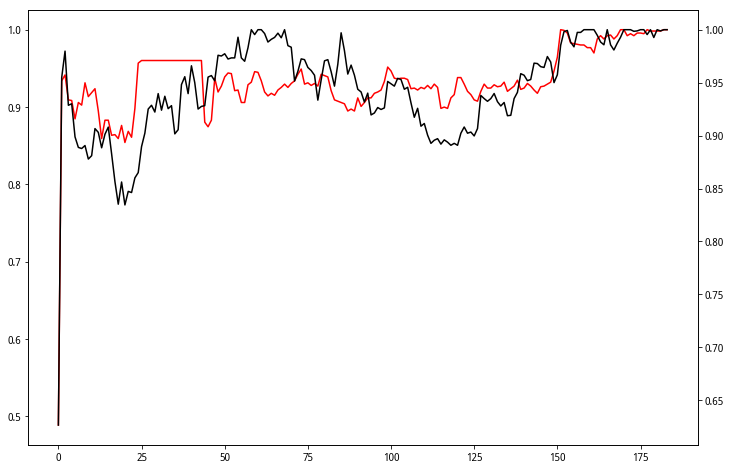

In [4]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
from dtw import dtw
from sklearn.metrics.pairwise import euclidean_distances
import time
from numpy import inf

ccl
pool = Series(get_index_stocks('000016.XSHG'))

#归一化所有股票的closeprice
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
closeprice = {}
      
for i in pool.index:
    closeprice[i] = get_price(pool[i],'2016-01-01','2016-10-01','1d',['close'])['close']    
    maxp, minp=max(closeprice[i]), min(closeprice[i])
    for k in range(len(closeprice[i])):
        closeprice[i][k] = (closeprice[i][k]-minp)/(maxp-minp)

        if closeprice[i][k]==np.NaN or closeprice[i][k]==inf:
            del closeprice[i]
            continue
        else:
            closeprice[i][k] = float("%.9f" % closeprice[i][k])
        
    print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))



dist_threshold = 3

for i in pool.index:
    k = i+1

    if i != pool.index[-1]:
        for m in range(k,pool.index[-1]+1):
            try:
                dist, cost, acc, path = dtw(closeprice[i],closeprice[m],dist=euclidean_distances)
            except:
                continue
            else:
                distance_ = acc[-1][-1]
            
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),'lalalalalalala')    
            
                if distance_ < dist_threshold:
                    print(distance_)
                    
                    fig_size = plt.rcParams['figure.figsize']
                    fig_size[0] = 12
                    fig_size[1] = 8
                    
                    fig,ax1=plt.subplots()
                    ax2 = ax1.twinx()
                
                    p1=ax1.plot(range(len(closeprice[i])),closeprice[i],'r')
                    p1=ax2.plot(range(len(closeprice[i])),closeprice[m],'k')
                    break
        else:
            continue
        break

如图所示，当dist_threshold设为3时，找出来的两支股票走势的相似度上还ok吧。这个阈值是我们尝试后设定的，然后我们就可以把股票池中所有的两两配对找出来了。当阈值设为2时，如下：

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
from dtw import dtw
from sklearn.metrics.pairwise import euclidean_distances
import time
from numpy import inf


pool = Series(get_index_stocks('000016.XSHG'))

#归一化所有股票的closeprice
closeprice={}
for i in pool.index:
    closeprice[i] = get_price(pool[i],'2016-01-01','2016-10-01','1d',['close'])['close']    
    for k in range(len(closeprice[i])):
        closeprice[i][k] = (closeprice[i][k]-min(closeprice[i]))/(max(closeprice[i])-min(closeprice[i]))

        if closeprice[i][k]==NaN or closeprice[i][k]==inf:
            del closeprice[i]
            continue
        else:
            closeprice[i][k] = float("%.9f" % closeprice[i][k])

#设定distance的阈值
dist_threshold = 2
stockpairs=[]
for i in pool.index:
    k = i+1

    if i != pool.index[-1]:
        for m in range(k,pool.index[-1]+1):
            try:
                dist, cost, acc, path = dtw(closeprice[i],closeprice[m],dist=euclidean_distances)
            except:
                continue
            else:
                distance_ = acc[-1][-1]   
            
                if distance_ < dist_threshold:
                    print(pool[i],pool[m],distance_)
                    

上面结果的第三列为accumulate_distance的值，我们可以取最小的那对股票，再直观验证一下。下面分别是他们的价格走势以及归一价格后的走势。


In [ ]:
i = get_price( '600016.XSHG','2016-01-01','2016-10-01','1d',['close'])['close']
m = get_price( '601288.XSHG','2016-01-01','2016-10-01','1d',['close'])['close']


fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 8
                    
fig,ax1=plt.subplots()
ax2 = ax1.twinx()

p1=ax1.plot(range(len(i)),i,'r')
p1=ax2.plot(range(len(m)),m,'k')

In [ ]:
for k in range(len(i)):
        i[k] = (i[k]-min(i))/(max(i)-min(i))

for k in range(len(m)):
        m[k] = (m[k]-min(m))/(max(m)-min(m))
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 8
                    
fig,ax1=plt.subplots()
ax2 = ax1.twinx()

p1=ax1.plot(range(len(i)),i,'r')
p1=ax2.plot(range(len(m)),m,'k')

本文仅提供一个寻找走势匹配股票的思路，今后还会将此算法，结合不同的形态用于不同的策略中。欢迎大家来指点不足。